<h1>KNN Classification</h1>

<h3>1. Load and preprocess the data</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/tracks_with_binary_target.csv')
data.set_index(['title'], inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [4]:
data[data.columns.drop(['year', 'is_dance_pop'])].describe()

,followers,artist_popularity,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,17.029588,84.018405,118.815216,69.878067,65.037730,-5.544931,17.945951,52.562193,222.775718,15.214768,8.682209,67.777607
std,16.243704,7.961677,24.404749,16.215948,13.212029,1.771109,13.490322,22.371560,34.748892,21.457495,7.944160,14.441404
min,0.045373,52.000000,43.000000,4.000000,23.000000,-15.000000,2.000000,4.000000,134.000000,0.000000,2.900000,0.000000
25%,5.470647,80.000000,100.000000,60.000000,58.000000,-6.849750,9.000000,35.000000,200.000000,2.000000,4.000000,61.000000
50%,10.823572,85.000000,120.000000,73.000000,67.000000,-5.000000,12.000000,53.000000,219.000000,6.000000,5.880000,70.000000
75%,22.810986,89.000000,129.000000,81.150000,74.000000,-4.000000,24.250000,69.550000,238.000000,19.000000,10.000000,78.000000
max,80.746303,99.000000,206.000000,98.000000,97.000000,-2.000000,79.200000,98.000000,424.000000,99.000000,48.700000,99.000000


Because the KNN algorithm cannot work with categorical features expressed as string values, we need to use LabelEncoder to encode them to integer values. I am not using OneHotEncoding since the number of possible categories for artist is large. <br>
Additionally, scaling is critical for the algorithm so it is performed next.

In [5]:
data[['artist']] = data[['artist']].apply(LabelEncoder().fit_transform)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop(['is_dance_pop'])],
    data['is_dance_pop'],
    test_size=0.2,
    random_state=24
)

In [7]:
X, Y = data[data.columns.drop(['is_dance_pop'])], data['is_dance_pop']

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train[X_train.columns.drop(['artist', 'year'])])
X_train[X_train.columns.drop(['artist', 'year'])] = scaler.transform(X_train[X_train.columns.drop(['artist', 'year'])] )
X_test[X_test.columns.drop(['artist', 'year'])] = scaler.transform(X_test[X_test.columns.drop(['artist', 'year'])] )
X[X.columns.drop(['artist', 'year'])] = scaler.transform(X[X.columns.drop(['artist', 'year'])])

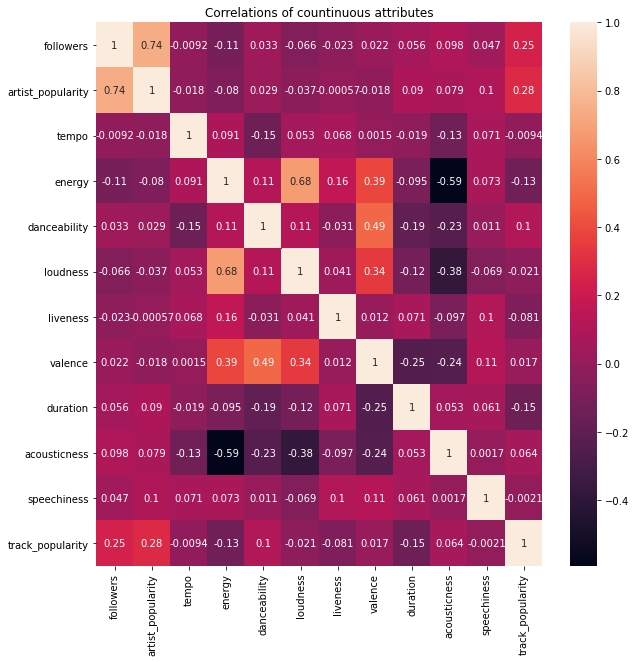

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'year', 'is_dance_pop'])].corr(), annot=True)
plt.title('Correlations of countinuous attributes')
plt.show()

<h3>2. KNN Classification</h3>

KNN does not make any assumptions about the data so testing correlations will not be of any benefit.

Since the data is of different types, we have: nominal, ordinal, interval and ration attributes, i am going to define a custom metric. <br>
Binary (target): is_dance_pop <br>
Nominal attributes: title(not used), artist<br>
Ordinal attributes: year (2010 - 2020)<br>
Interval: loudness<br>
Ratio: other

In [10]:
def custom_metric(x, y):
  score = 0
  val = (x[0]!=y[0])**2 #for artist (nominal)
  score += val
  count = 0

  for xi, yi in zip(x[1:], y[1:]):
    if count == 2:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

In [11]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(model, X, Y)

  return predicted, actual, score

In [29]:
errors = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine',custom_metric]

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    pred_i, act_i, score_i = cross_validation_model(X, Y, knn)
    err = np.mean([1 if pred_i[i] != act_i[i] else 0 for i in range(len(pred_i))])
    node.append(err)
  errors.append(node)   

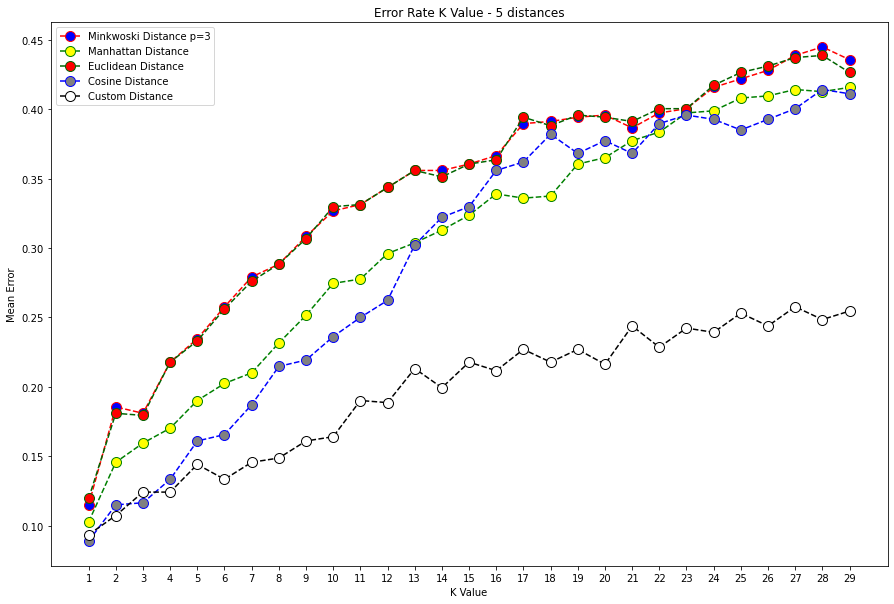

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

<h4>The cosine metric has the lowest error for 1 neighbor, the custom metric has the lowest error for 2 neighbors. Although the lowest errors are for one neighbor for each data point, I am not going to chose one neighbor since it is almost certain that this would be overfitting. I am going to compromise and choose 2 as the nearest neighbors. The custom metric has the overall lowest average error compared to all of the other metrics which is expected since the data has attribtes of different types.</h4>

In [46]:
clf = KNeighborsClassifier(n_neighbors=2, metric=custom_metric)
clf.fit(X_train, Y_train)
y_pred_holdout = clf.predict(X_test)

In [47]:
print(classification_report(Y_test, y_pred_holdout))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        57
           1       0.94      0.92      0.93        74

    accuracy                           0.92       131
   macro avg       0.92      0.92      0.92       131
weighted avg       0.92      0.92      0.92       131



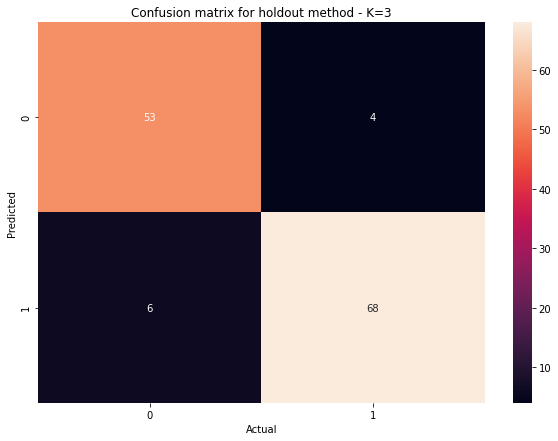

In [48]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test, y_pred_holdout), annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for holdout method - K=3')
plt.show()

Knn only missclassifies 10 points that are actualy dance pop, predicting them as non dance pop tracks.

In [42]:
cv_predictions, cv_actual, cv_score = cross_validation_model(X, Y, KNeighborsClassifier(n_neighbors=2, metric=custom_metric))

In [43]:
cv_score

array([0.85496183, 0.85496183, 0.90769231, 0.87692308, 0.76153846])

In [44]:
print(classification_report(cv_actual, cv_predictions))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       315
           1       0.93      0.86      0.89       337

    accuracy                           0.89       652
   macro avg       0.89      0.89      0.89       652
weighted avg       0.90      0.89      0.89       652



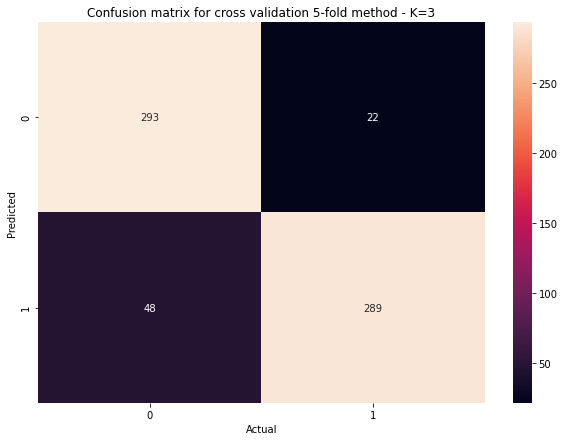

In [45]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(cv_actual, cv_predictions), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for cross validation 5-fold method - K=3')
plt.show()

The cross validation scores are a bit lower than the scores on the heldout method. This may be due to the randomness of the split. Since the difference in scores is not significant, we may assume the model is not overfit.

KNN has a problem with high dimensional data. Let's see how it performes with PCA reduced dimensionality of the data set.

In [50]:
pca = PCA(5)
X_decomposed = pca.fit_transform(X[X.columns.drop(['artist', 'year'])])

In [51]:
X_train_dec, X_test_dec, Y_train_dec, Y_test_dec = train_test_split(
    X_decomposed,
    Y,
    test_size = 0.2,
    random_state = 0
)

In [52]:
pca.explained_variance_ratio_

array([0.25558697, 0.17519655, 0.1234875 , 0.09233527, 0.07144358])

Total explained variance = 0.71804987

The custom metric does not make sense in this case, so we will not use it.

In [57]:
errors_2 = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine']

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    pred_i, act_i, score_i = cross_validation_model(pd.DataFrame(X_decomposed), Y, knn)
    err = np.mean([1 if pred_i[i] != act_i[i] else 0 for i in range(len(pred_i))])
    node.append(err)
  errors_2.append(node)   

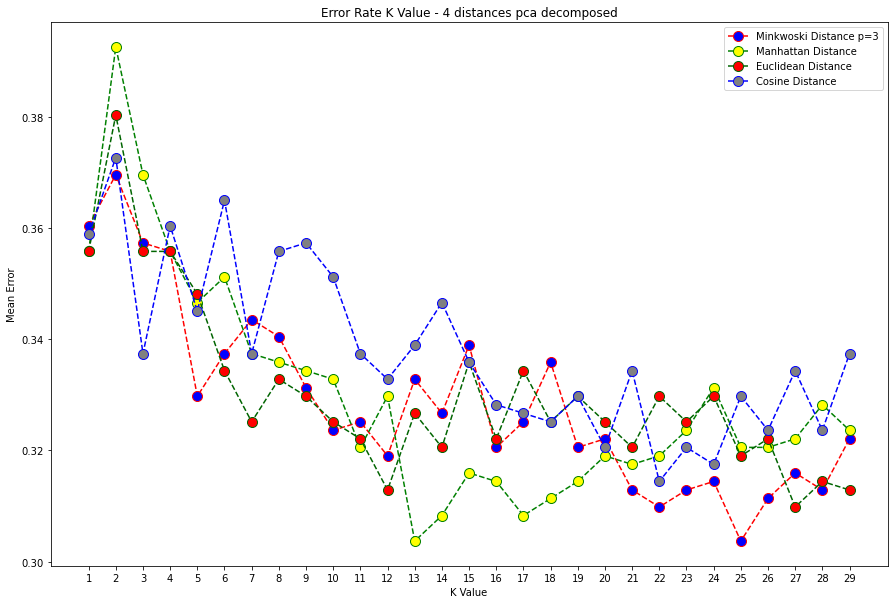

In [58]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors_2[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors_2[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors_2[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors_2[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.title('Error Rate K Value - 4 distances pca decomposed')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

We can see that the cosine distance is the worst, and manhattan distance has the best results. The best result come from manhattan distance and 13 neighbors.

In [60]:
X_decomposed = pd.DataFrame(X_decomposed)

In [61]:
knn_dec = KNeighborsClassifier(n_neighbors=13, metric='manhattan')
knn_dec.fit(X_train_dec, Y_train_dec)
y_pred_dec_hold = knn_dec.predict(X_test_dec)

In [62]:
print(classification_report(Y_test_dec, y_pred_dec_hold))

              precision    recall  f1-score   support

           0       0.77      0.53      0.63        64
           1       0.66      0.85      0.74        67

    accuracy                           0.69       131
   macro avg       0.71      0.69      0.68       131
weighted avg       0.71      0.69      0.69       131



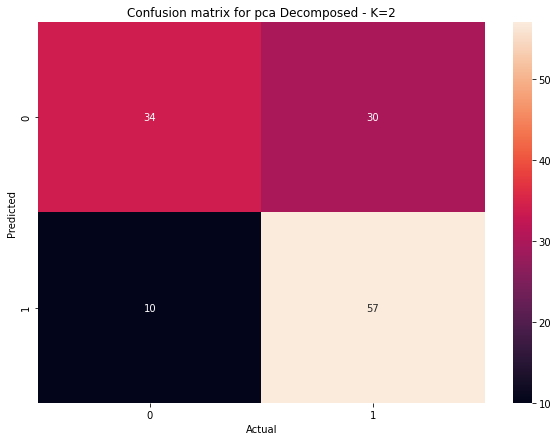

In [63]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test_dec, y_pred_dec_hold), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for pca Decomposed - K=2')
plt.show()

We can see that the method performs worse with the pca decomposed features than with the original features. But this time it uses manhattan distance insead of the custom distance. This may be due to the components not capturing enough of the variance in the original data to make it distinguishable.

<h3>3. KNN Regression</h3>

In [64]:
def cross_validation_model_reg(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())

  return predicted, actual

This time lets try regression, with followers as the target attribute.

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [66]:
data = pd.read_csv('../data/final_spotify_tracks.csv')
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Encode the values of artist and top genre with label encoder and then scale.

In [67]:
data[['artist', 'top genre']] = data[['artist', 'top genre']].apply(LabelEncoder().fit_transform)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,4,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,58,3,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,103,4,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,108,4,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,26,4,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [76]:
data = data.fillna(data.median())

In [77]:
X = data.drop('track_popularity', axis=1)
Y = data['track_popularity']

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size = 0.2,
    random_state = 5
)

In [79]:
scaler.fit(X_train[X_train.columns.drop(['artist', 'top genre', 'year'])])
X_train[X_train.columns.drop(['artist', 'top genre', 'year'])] = scaler.transform(X_train[X_train.columns.drop(['artist', 'top genre', 'year'])])
X_test[X_test.columns.drop(['artist', 'top genre', 'year'])] = scaler.transform(X_test[X_test.columns.drop(['artist', 'top genre', 'year'])])
X[X.columns.drop(['artist', 'top genre', 'year'])] =  scaler.transform(X[X.columns.drop(['artist', 'top genre', 'year'])])

In [80]:
def custom_metric_2(x, y):
  score = 0
  score += (x[0]!=y[0])**2 #for artist (nominal)
  score += (x[1]!=y[1])**2 #for top genre (nominal)
  
  count = 0
  for xi, yi in zip(x[2:], y[2:]):
    if count == 1:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

In [102]:
errors = []
rmse = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine', custom_metric_2]

for metric in metrics:
  inner_error = []
  inner_rmse = []
  for i in range(1, 30):
    knn = KNeighborsRegressor(n_neighbors=i, metric=metric, p=3)
    pred_i, act_i = cross_validation_model_reg(X, Y, knn)
    err = np.mean([np.abs(pred_i[i] - act_i[i]) for i in range(len(pred_i))])
    inner_error.append(err)
    inner_rmse.append(np.sqrt(mean_squared_error(pred_i, act_i)))
  errors.append(inner_error)
  rmse.append(inner_rmse)

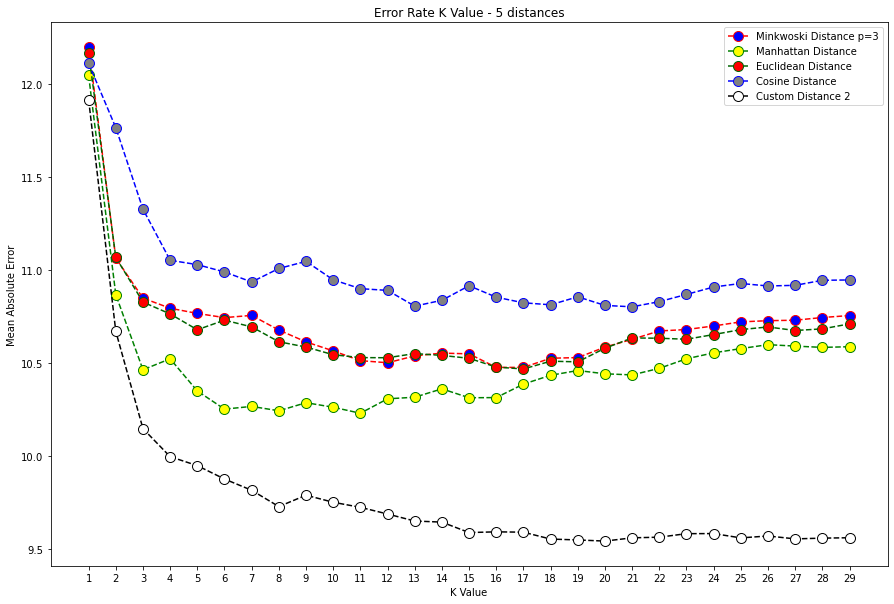

In [103]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance 2')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

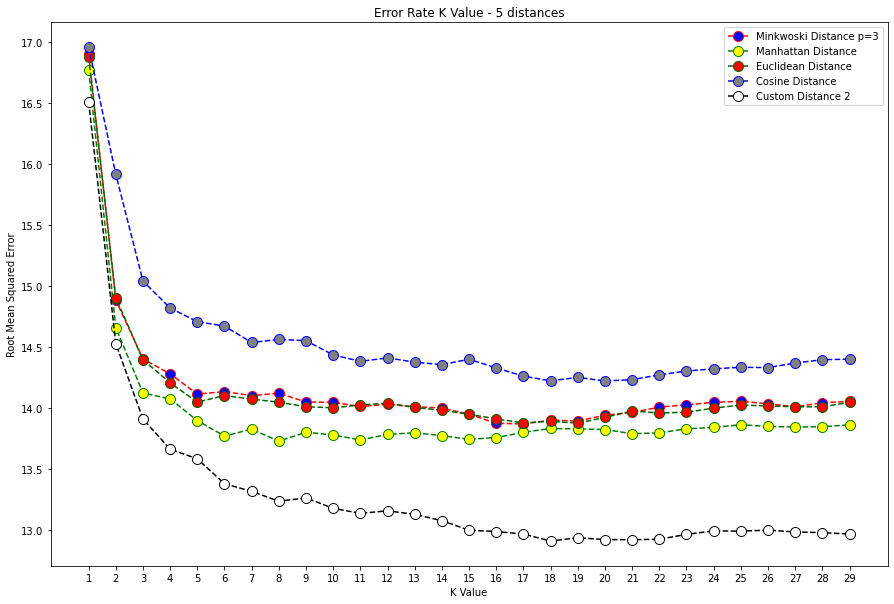

In [104]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), rmse[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), rmse[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), rmse[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), rmse[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), rmse[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance 2')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

The custom metric is again way better than the other metrics according to mae and rmse. For k = 18 the lowest rmse is achieved for the custom metric.

In [105]:
knn_reg = KNeighborsRegressor(n_neighbors=18, metric=custom_metric_2)
knn_reg.fit(X_train, Y_train)
y_pred_holdout = knn_reg.predict(X_test)

In [106]:
print(f'RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_holdout))}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred_holdout)}')
print(f'R2 score: {r2_score(Y_test, y_pred_holdout)}')

RMSE: 14.850130105504462
MAE: 9.546649703138252
R2 score: 0.20403852985482895


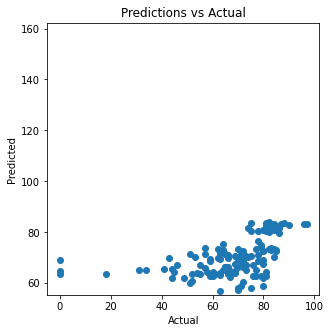

In [107]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test, y_pred_holdout)
plt.axis('square')
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [108]:
pred_cv, act_cv = cross_validation_model_reg(X, Y, knn_reg)

In [109]:
print(f'RMSE: {np.sqrt(mean_squared_error(pred_cv, act_cv))}')
print(f'MAE: {mean_absolute_error(pred_cv, act_cv)}')
print(f'R2 score: {r2_score(pred_cv, act_cv)}')

RMSE: 12.908252898065097
MAE: 9.554192229038854
R2 score: -2.6079129778507646


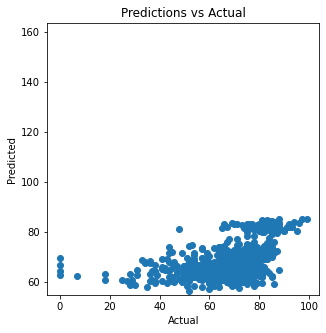

In [110]:
plt.figure(figsize=(5,5))
plt.scatter(act_cv, pred_cv)
plt.axis('square')
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

<h3>PCA decomposed</h3>

In [111]:
X_dec = pd.DataFrame(pca.fit_transform(X[X.columns.drop(['artist', 'year', 'top genre'])]))
print(pca.explained_variance_ratio_)

[0.26956195 0.18016687 0.13060633 0.09648565 0.07535729]


Total explained variance 0.75217809

In [112]:
X_dec_trin, X_dec_test, Y_dec_train, Y_dec_test = train_test_split(
    X_dec,
    Y,
    test_size=0.2,
    random_state=24
)

In [114]:
errors = []
rmse = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine']

for metric in metrics:
  inner_error = []
  inner_rmse = []
  for i in range(1, 50):
    knn = KNeighborsRegressor(n_neighbors=i, metric=metric, p=3)
    pred_i, act_i = cross_validation_model_reg(X_dec, Y, knn)
    err = np.mean([np.abs(pred_i[i] - act_i[i]) for i in range(len(pred_i))])
    inner_error.append(err)
    inner_rmse.append(np.sqrt(mean_squared_error(pred_i, act_i)))
  errors.append(inner_error)
  rmse.append(inner_rmse)

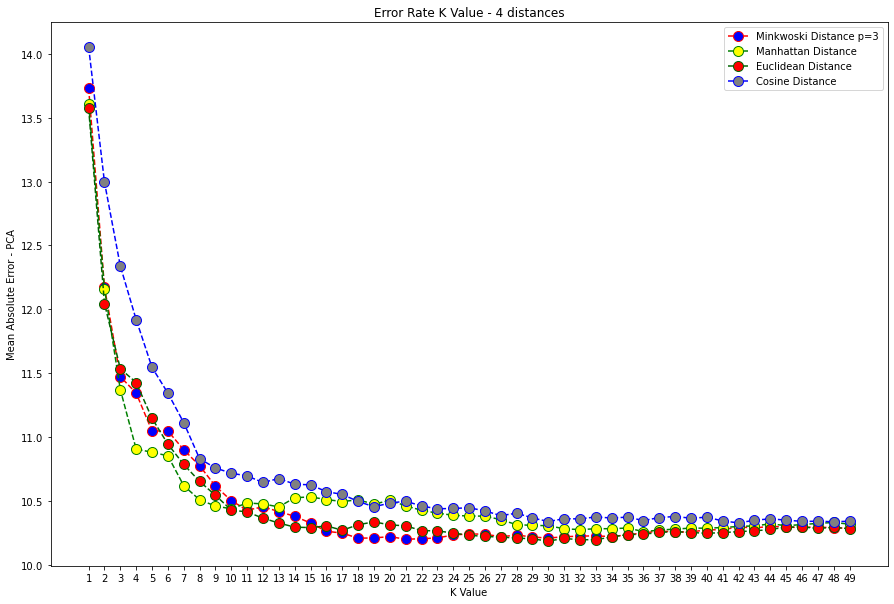

In [115]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 50), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 50), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 50), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 50), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.title('Error Rate K Value - 4 distances')
plt.xlabel('K Value')
plt.xticks(range(1,50))
plt.ylabel('Mean Absolute Error - PCA')
plt.legend()
plt.show()

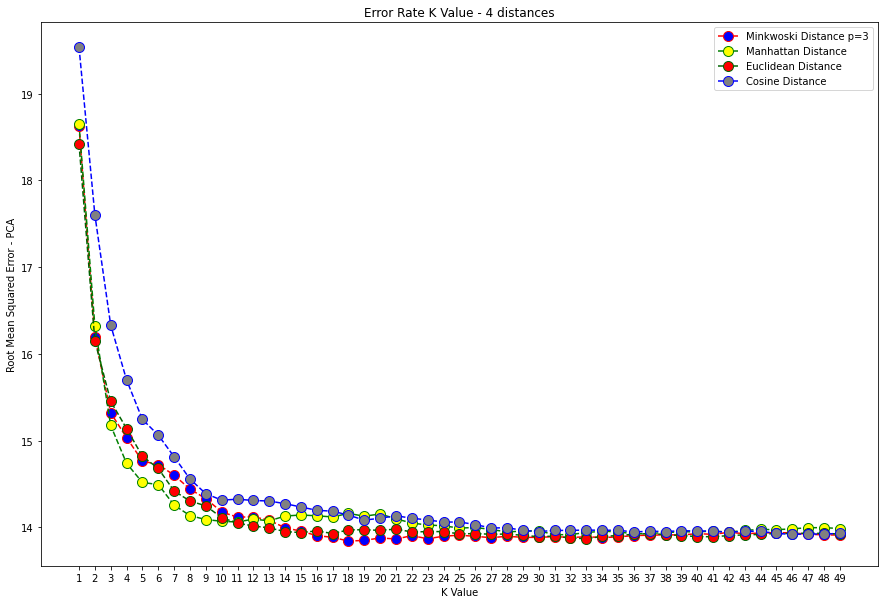

In [116]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 50), rmse[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 50), rmse[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 50), rmse[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 50), rmse[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.title('Error Rate K Value - 4 distances')
plt.xlabel('K Value')
plt.xticks(range(1,50))
plt.ylabel('Root Mean Squared Error - PCA')
plt.legend()
plt.show()

I am going to choose k=18 and metric = minkowski distance p=3 since in both cases it reaches the lowest errors.

In [117]:
knn_reg_pca = KNeighborsRegressor(n_neighbors=18, metric='minkowski', p=3)
knn_reg_pca.fit(X_train, Y_train)
y_pred_pca = knn_reg_pca.predict(X_test)

In [118]:
print(f'RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_pca))}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred_pca)}')
print(f'R2 score: {r2_score(Y_test, y_pred_pca)}')

RMSE: 15.759868552437975
MAE: 10.822307039864292
R2 score: 0.10352804040760177


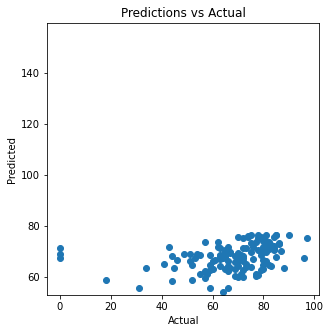

In [119]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test, y_pred_pca)
plt.axis('square')
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

These scores are very close to the ones with the original data. But the error distribution is not very good. Maybe knn regression does not model this data well.